<a href="https://colab.research.google.com/github/wisrovi/SAM/blob/master/Red%20Neuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Vamos a necesitar usar la GPU de la maquina
#####Entorno de ejecución/cambiar tipo de entorno de ejecución/acelerador por hardware / GPU
### Si Esto no se hace, no se podrá usar el reconocimiento facial


In [39]:
#instalamos las librerias que no vienen preinstaladas
!pip3 install dlib
!pip install cmake
!pip3 --no-cache-dir install face_recognition

In [0]:
#Confirmamos que la instalación haya sido exitosa
import dlib
import face_recognition

In [41]:
#asociamos nuestra cuenta de google para que el sistema guarde allí los archivos y datos que se procesaran

raiz = '/content/drive/'

#API google colab con google drive
from google.colab import drive
drive.mount(raiz)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
def verContenidoCarpeta():
  a = !ls "/content/drive/My Drive/Redes Neuronales"
  return a

In [46]:
a = verContenidoCarpeta()
if len(a)>0:
  if str(a[0]).index('cannot access') > 0:
    print("El directorio no existe, creando el directorio")
    !mkdir "/content/drive/My Drive/Redes Neuronales"
else:
  print("El directorio esta vacio")

El directorio no existe, creando el directorio


In [47]:
verContenidoCarpeta()

[]

In [48]:
def descargarArchivos():
  !git clone https://github.com/wisrovi/SAM "/content/drive/My Drive/Redes Neuronales"

descargarArchivos()

Cloning into '/content/drive/My Drive/Redes Neuronales'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 48 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [49]:
verContenidoCarpeta()

[' deploy.prototxt.txt    README.md',
 " example_opencv3-2.py  'Red Neuronal.ipynb'",
 ' OpenCV_3.py\t        res10_300x300_ssd_iter_140000.caffemodel',
 ' presentacionRNA.ppt    samantha.apk']

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image

<IPython.core.display.Javascript object>

Saved to wisrovi.jpg


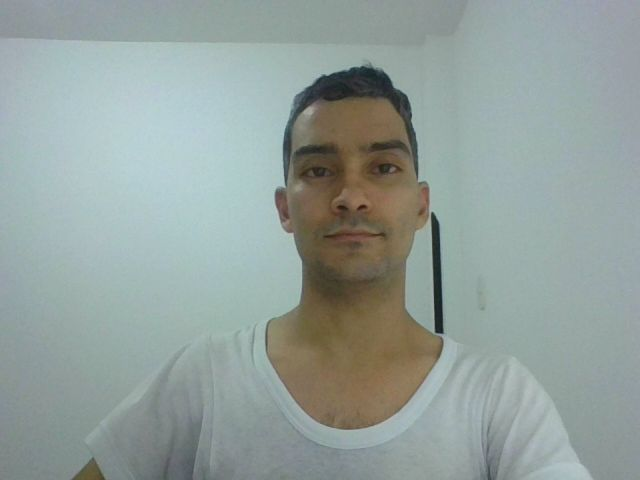

In [52]:
nombreGuardarImagen = "wisrovi.jpg"
def TomarGuardarFoto():
  try:
    filename = take_photo(nombreGuardarImagen)
    print('Saved to {}'.format(filename))
    display(Image(filename))
  except Exception as err:
    print(str(err))
    
TomarGuardarFoto()

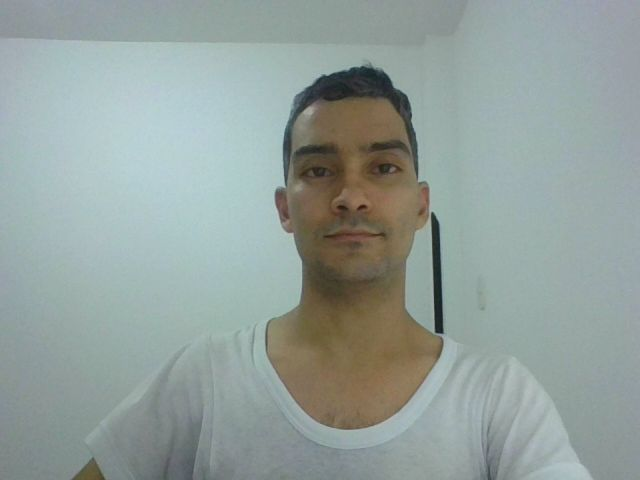

In [53]:
#confirmamos que la foto se guardo y la podremos usar mas adelante

from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread(nombreGuardarImagen, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [54]:
#Cargamos los archivos:
#deploy.prototxt.txt -> Estructura de la red neuronal
#res10_300x300_ssd_iter_140000.caffemodel -> Pesos de la red neuronal
#Libreria que configura y usa la red neuronal

from google.colab import files
files.upload()

#Esta red neuronal fue entrenada por: thegopieffect y las fuentes originales estan en:
#https://github.com/thegopieffect/computer_vision/tree/master/CAFFE_DNN

Saving deploy.prototxt.txt to deploy.prototxt (1).txt
Saving OpenCV_3.py to OpenCV_3 (1).py
Saving res10_300x300_ssd_iter_140000.caffemodel to res10_300x300_ssd_iter_140000 (1).caffemodel


In [0]:
#Cargamos la red neuronal de deteccion de rostros
#si bien OpenCV tiene un Haarscade para la detección, esta no es muy rápida y ademas en el menor angulo de inclinación de rostros deja de detectar
from OpenCV_3 import OpenCV_3
detecFaces = OpenCV_3()
detecFaces.setConfianzaDeteccion(0.40)

In [0]:
#Cargamos la imagen en una variable usando OpenCv
frame = cv2.imread(nombreGuardarImagen, cv2.IMREAD_COLOR)
photo = frame.copy()

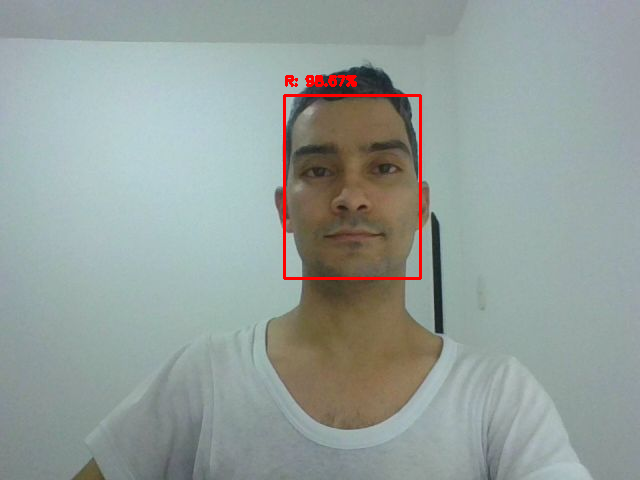

In [73]:
#Buscamos los rostros y dibujamos un recuadro alrededor del rostro, ademas indicamos el porcentaje de detección de la red neuronal

listadoCoordenadasRostros = detecFaces.detectarRostros(frame)
for (startX, startY, endX, endY, confianzaEsteRostro) in listadoCoordenadasRostros:
  cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 0, 255), 2)

  text = "R: " + "{:.2f}%".format(confianzaEsteRostro * 100)
  y = startY - 10 if startY - 10 > 10 else startY + 10
  cv2.putText(frame, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

  rostroColor = frame[startY:endY, startX:endX]
cv2_imshow(frame)

In [74]:
import face_recognition
image = face_recognition.load_image_file(nombreGuardarImagen)
face_locations = face_recognition.face_locations(image)
print("Cara encontrada en: ", face_locations)

Cara encontrada en:  [(133, 425, 288, 270)]


## Ahora vamos a extraer los puntos caracteristicos

<img src="https://lh3.googleusercontent.com/-_qd-G1852mU/WgRYbIKNbaI/AAAAAAAADzg/FvnCvaLfctgmjBphMAD44O61Hhxl0e3_wCHMYCw/facial_landmarks_68markup_thumb?imgmax=800" width="600">

### Miremos los puntos encontrados

Categoria: chin 	 Puntos encontrados:[(283, 183), (284, 201), (288, 218), (292, 235), (297, 251), (307, 265), (321, 275), (338, 282), (357, 284), (375, 280), (391, 272), (403, 262), (412, 248), (417, 232), (420, 215), (422, 197), (422, 179)]
Categoria: left_eyebrow 	 Puntos encontrados:[(290, 161), (297, 149), (311, 144), (326, 144), (340, 148)]
Categoria: right_eyebrow 	 Puntos encontrados:[(360, 146), (375, 141), (390, 139), (404, 144), (412, 156)]
Categoria: nose_bridge 	 Puntos encontrados:[(351, 164), (351, 175), (351, 186), (351, 197)]
Categoria: nose_tip 	 Puntos encontrados:[(337, 211), (345, 212), (352, 214), (360, 212), (367, 210)]
Categoria: left_eye 	 Puntos encontrados:[(305, 174), (313, 168), (323, 168), (332, 173), (323, 176), (313, 176)]
Categoria: right_eye 	 Puntos encontrados:[(370, 171), (380, 165), (389, 165), (397, 169), (390, 173), (380, 173)]
Categoria: top_lip 	 Puntos encontrados:[(325, 237), (336, 232), (346, 228), (353, 230), (360, 228), (370, 231), (383, 23

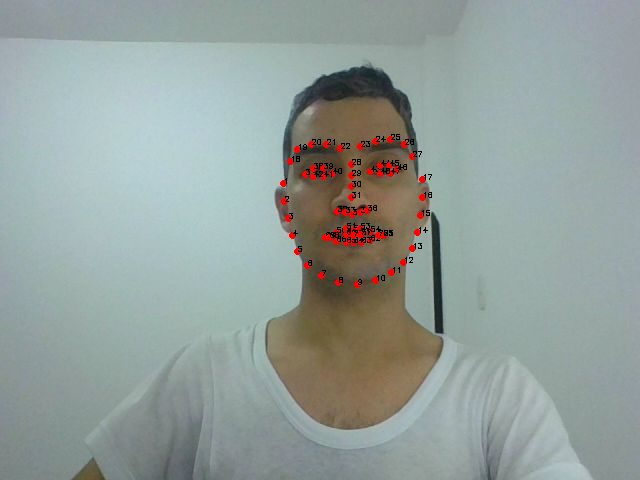

In [89]:
face_landmarks_list = face_recognition.face_landmarks(image)

categoriaPuntos = [
    "chin",
    "left_eyebrow",
    "right_eyebrow",
    "nose_bridge",
    "nose_tip",
    "left_eye",
    "right_eye",
    "top_lip",
    "bottom_lip"
]

numeroPunto = 0
diccionarioPuntos = face_landmarks_list[0]
for categoria in range(len(categoriaPuntos)):
  categoriaPuntos[categoria]
  print("Categoria: ", end="")
  print(categoriaPuntos[categoria], end=" \t ")
  print("Puntos encontrados:", end="")
  vectorPuntos = diccionarioPuntos[categoriaPuntos[categoria]]
  print(vectorPuntos)
  
  for punto in vectorPuntos:
    numeroPunto += 1
    radius = 2
    photo = cv2.circle(photo, punto, radius, (0, 0, 255), 2) 
    cv2.putText(photo, str(numeroPunto), punto, cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0, 0, 0), 1)

cv2_imshow(photo)

### Ahora codifiquemos estos datos para que no sean tan trasparentes, esto se hace para la protección de los datos

#### Con esto tendremos los datos en una plantilla unica de caracteristicas

In [0]:
def ExtraerVectorCaractersticas(nombreArchivo):
  image = face_recognition.load_image_file(nombreArchivo)
  person_encoding = face_recognition.face_encodings(image)[0]
  return person_encoding

In [91]:
vectorPersonaConocida = ExtraerVectorCaractersticas(nombreGuardarImagen)
print("Vector de caracteristicas: ", vectorPersonaConocida)

Vector de caracteristicas:  [-0.11963981  0.22676623 -0.00601398 -0.06607139 -0.01328157 -0.02854939
 -0.02045591 -0.08111429  0.24751841 -0.10589433  0.20747304 -0.01964021
 -0.18581316 -0.1100319  -0.0708311   0.12347154 -0.24062872 -0.16881096
 -0.086705   -0.08803084  0.07103601  0.12563092  0.00489192  0.05346682
 -0.17037216 -0.30748314 -0.04782448 -0.17608958 -0.00798449 -0.10065085
 -0.01929834  0.0275105  -0.11548641 -0.05614121  0.02009843  0.1100176
 -0.00525656 -0.03428983  0.21697408  0.05567242 -0.12758967 -0.03256033
  0.07127655  0.39439434  0.1992704  -0.01677191 -0.02123817 -0.07326693
  0.18066594 -0.1951848   0.03411681  0.15840568  0.1220566   0.06994241
  0.15738589 -0.11702074  0.01031661  0.1027851  -0.20956641 -0.01207761
  0.02514955 -0.01935002 -0.00741518 -0.02885567  0.25421205  0.08896205
 -0.10108873 -0.04043439  0.18957664 -0.13109224 -0.074806    0.03728213
 -0.10562666 -0.15023465 -0.23388107  0.00970241  0.46613944  0.12879165
 -0.12276362  0.06221629

#### Con este vector almacenado en una base de datos, ya podremos guardar los datos de la persona (sin guardar la imagen) y podremos consultar el vector cuando se requiera y compararlo con otro vector para ver si es la misma persona.

In [0]:
#Creamos un vector con las personas conocidas 
#(Nota: debe ser un vector y pueden haber tantas personas identificadas como se desee)

personasConocidas = [
    vectorPersonaConocida
]

#Creamos tambien un vector con los nombres de las personas
nombrePersona = [
    "WISROVI"
]

<IPython.core.display.Javascript object>

Saved to desconocido.jpg


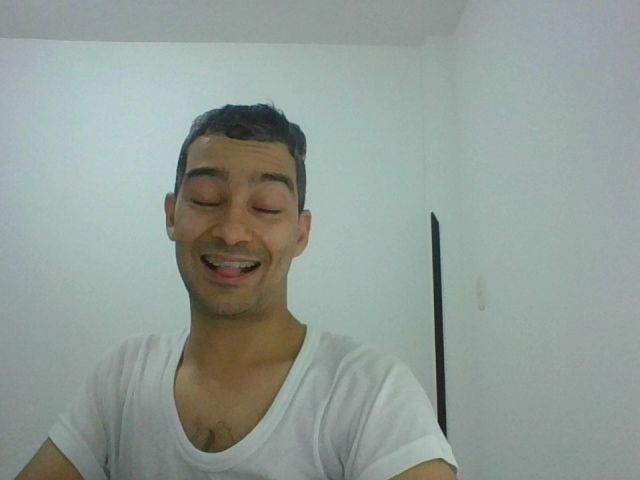

In [93]:
#Tomemos una nueva foto
nombreGuardarImagen = "desconocido.jpg"
TomarGuardarFoto()

In [0]:
#Hallamos el vector del nuevo rostro
unknown_image = face_recognition.load_image_file(nombreGuardarImagen)
vector_persona_desconocida = face_recognition.face_encodings(unknown_image)[0]

In [108]:
#Ahora vamos a buscar este nuevo vector entre los rostros ya conocidos
vector_respuesta_persona_reconocida_segun_lista_personasConocidas = face_recognition.compare_faces(personasConocidas, vector_persona_desconocida)

print(vector_respuesta_persona_reconocida_segun_lista_personasConocidas)

[True]


In [96]:
#Pero como un vector de detección no es algo legible para el usuario, debemos convertir ese vector en el nombre
def TraducirVectorRespuestaEnNombre(vector):
  if True in vector:
    indice = vector.index(True)  
    return nombrePersona[indice]
    
    
nombrePersonaFrenteCamara = TraducirVectorRespuestaEnNombre(vector_respuesta_persona_reconocida_segun_lista_personasConocidas)
print("La persona frente a la cámara es: ", nombrePersonaFrenteCamara)

La persona frente a la cámara es:  WISROVI


### Identifiquemos a la persona en la imagen

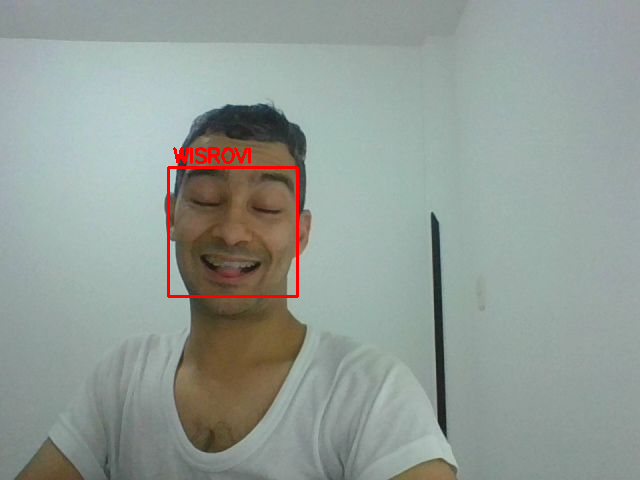

In [106]:
#Cargamos la imagen en una variable
frame = cv2.imread(nombreGuardarImagen, cv2.IMREAD_COLOR)

#Hallamos las coordenadas del rostro
face_locations = face_recognition.face_locations(frame)[0]
startX, startY, endX, endY = face_locations[0], face_locations[1], face_locations[2], face_locations[3] 

#Colocamos un rectangulo en el rostro
cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 0, 255), 2)

#ponemos el nombre de la persona en el rostro
cv2.putText(frame, nombrePersonaFrenteCamara, (startX + 5, endY - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2)

#mostramos la imagen con el reconocimiento puesto
cv2_imshow(frame)

### Borrar el directorio y su contenido del drive, esto en caso de que no se quiera conservar la información

In [0]:
try:
  !rm -r "/content/drive/My Drive/Redes Neuronales"
except:
  pass